# Displacement controlled normal contact
***
In this notebook we will make a contact model which solves a normal contact problem with a specified displacement. 

For normal contact problems with specified loads see the 'recreating the hertz solition numerically' example.

Here again we will use the hertz solution as an easy way to verify that we are getting sensible results.

First lets import everything we will need (no one actually writes these first it's just convention to put them at the top of the file)

In [1]:
import slippy.surface as s      # surface generation and manipulation
import slippy.contact as c      # contact modelling
import numpy as np              # numerical functions 
import matplotlib.pyplot as plt # plotting

## Making the surfaces
In order to solve the problem the geometry must be set. As we are solving the hertz problem we will use an analytically defined round surface and an analytically defined flat surface. For your own analyses the geometry data can come from experimental data or be generated randomly. For more information on this see examples about the surface class and the analytical surfaces.

Importantly at least one of the surfaces must be discrete to be used in a contact model.

In [2]:
flat_surface = s.FlatSurface(shift=(0, 0))
round_surface = s.RoundSurface((1, 1, 1), extent=(0.006, 0.006), 
                               shape=(255, 255), generate=True)

## Setting the materials 
The material for each surface must also be set. This material controls the deformation behaviour of the surface, the fricition and wear behaviour must be set separately. Please see tutorials on adding sub models to the step for more information.

In [3]:
# set materials
steel = c.Elastic('Steel', {'E': 200e9, 'v': 0.3})
aluminum = c.Elastic('Aluminum', {'E': 70e9, 'v': 0.33})
flat_surface.material = aluminum
round_surface.material = steel

## Making a contact model
Now we have surfaces and materials, but we need a contact model to hold this information and control the solving of model steps, this will become more important when we have multiple steps but for now think of the contact model as a container that all of the information is put in.

In [4]:
# create model
my_model = c.ContactModel('model-1', round_surface, flat_surface)

## Making a model step and adding it to the model
A step defines what happens to the surfaces during a set period. Here we will add a step that sets the interferance between the surfaces from the point of first touching. The resulting loads on the surfaces and deflections at each point on the surface will be found.

This can then be combined with ther sub models to specify friction or wear behaviour etc. however in this example we will simply compare the results back to the hertz solution. In order to do this we will use the analytical hertz solver to generate a sensible interferance.

In [5]:
# Find the analytical result
anal_result = c.hertz_full([1, 1], [np.inf, np.inf], [200e9, 70e9], [0.3, 0.33], 100)

# Make the model step
my_step = c.StaticStep(step_name='This is the step name',
                       interference=anal_result['total_deflection'])
# Add the step to the model
my_model.add_step(my_step)

## Model steps
The steps of the model are stored in the steps property of the model, this is an ordered dictionary, with the keys being the same as the step names. To retrieve a step you can index thie dictionary with the step name. However, if you try to add two steps with the same name the first will be overwritten. 

In [6]:
my_model.steps

OrderedDict([('Initial', InitialStep(model = None, name = initial)),
             ('This is the step name',
              StaticStep(This is the step name, time_period=1.0,off_set_x=0.0, off_set_y=0.0,normal_load=None, interference=1.1886938096020666e-06relative_loading:=False, adhesion=True,unloading=False, profile_interpolation_mode=nearest,periodic_geometry=False, periodic_axes(False, False),max_it_interference=100, rtol_interference:0.001,max_it_displacement=None, rtol_displacement=0.0001))])

## Solving the model
The entire model can then be solved using the solve method of the contact model. This will run through all the steps in order and return the model state at the end of the last step. Other information can be saved using output requests, but as we only have one step there is no need for this. 

Before running, by default the model will data check it's self, this action checks that each step and sub model can be solved with the information from the current state. It dosen't check for numerical stabiltiy or accuracy. This can be skipped if necessary.

In [7]:
final_state = my_model.solve()

## Checking the model against the analytical result
Now lets check the model results against the analytical result from the hertz solution. Althoug this particular step directly sets the interferance, most steps in slippy are solved iteratively, so it is a good idea to check that the set parameter converged to the desired value:

In [8]:
print('Solution converged at: ', final_state['interference'], ' interferance')
print('Set interferance was:', anal_result['total_deflection'])

Solution converged at:  1.1886938096020666e-06  interferance
Set interferance was: 1.1886938096020666e-06


Lets check the maximum pressure, contact area and total load all match up with the analytical values:

In [9]:
print('Analytical total load: ', 100)
print('Numerical total load: ', 
      round_surface.grid_spacing**2*sum(final_state['loads'].z.flatten()))

print('Analytical max pressure: ', anal_result['max_pressure'])
print('Numerical max pressure: ', max(final_state['loads'].z.flatten()))

print('Analytical contact area: ', anal_result['contact_area'])
print('Numerical contact area: ', 
      round_surface.grid_spacing**2* sum(final_state['contact_nodes'].flatten()))

Analytical total load:  100
Numerical total load:  100.02154306073318
Analytical max pressure:  40167183.96434862
Numerical max pressure:  40165072.18373249
Analytical contact area:  3.7343917396135165e-06
Numerical contact area:  3.7624913494809693e-06


## Checking the form of the result
We can also check that the individual surface loads line up with the analytical solution:

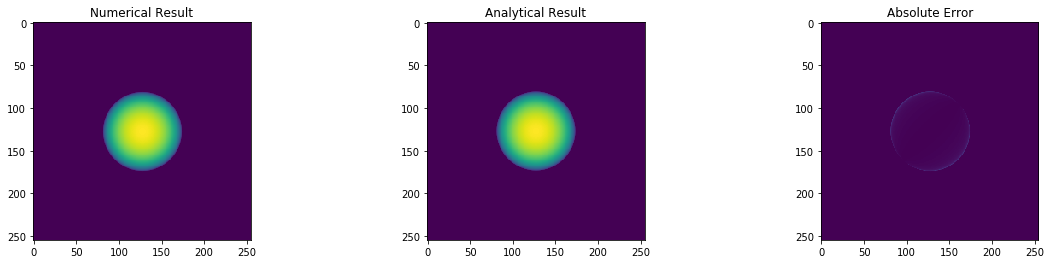

In [10]:
fig = plt.figure(figsize=(20, 4))
X,Y = round_surface.get_points_from_extent()
X,Y = X-X[-1,-1]/2 , Y-Y[-1,-1]/2
ax_0 = fig.add_subplot(131)
Z_n = final_state['loads'].z
ax_0.imshow(Z_n)
ax_0.set_title('Numerical Result')

R = np.sqrt(X**2+Y**2)
Z_a = anal_result['pressure_f'](R)
ax_1 = fig.add_subplot(132)
ax_1.imshow(Z_a)
ax_1.set_title('Analytical Result')

ax_2 = fig.add_subplot(133)
ax_2.imshow(np.abs(Z_a-Z_n))
for im in plt.gca().get_images():
    im.set_clim(0, anal_result['max_pressure'])
_ = ax_2.set_title('Absolute Error')

## Other items in the state dict
Other items can be listed from the state dict by the following code:

In [11]:
print(list(final_state.keys()))


['just_touching_gap', 'surface_1_points', 'surface_2_points', 'time', 'time_step', 'new_step', 'off_set', 'loads', 'total_displacement', 'surface_1_displacement', 'surface_2_displacement', 'contact_nodes', 'total_normal_load', 'interference', 'converged', 'gap']


- __off_set__ : The horizonatal distance between the origins of the surfces at the end of the step, **(2 element list)**
- __interferance__ : The displacement of the surfaces toward each other from the point of first touching at the end of the step, **float**
- __loads__ : The pressure on each grid point in the surface, in the x, y and z directions, **named tuple with fields x, y and z**
- __total_disp__ : The total deflection of each of surface grid points in the x, y and z directions, **named tuple with fields x, y and z**
- __surf_1_disp__, __surf_2_disp__ : The displacements on each of the surface points for the first and second surface, **named tuple with fields x, y and z**
- __contact_nodes__ : The nodes which are in contact for surface 1 only, **numpy boolean array**
- __gap__ : The undeformaed gap between the surfaces

In [12]:
# getting the deformed gap between the surfaces
def_gap = (final_state['gap'] - final_state['interference'] + final_state['total_displacement'].z)
plt.imshow(def_gap)

KeyError: 'total_disp'